# Explora aquí

Se recomienda utilizar este cuaderno con fines de exploración.

In [1]:
import pandas as pd
import requests
from io import StringIO

url = "https://en.wikipedia.org/wiki/List_of_most-streamed_songs_on_Spotify"
headers = {"User-Agent": "Mozilla/5.0"}

res = requests.get(url, headers=headers)
res.raise_for_status()

tables = pd.read_html(StringIO(res.text))
df = tables[0].copy()

df = df.rename(columns={
    "Song": "title",
    "Artist(s)": "artist",
    "Streams (billions)": "streams_billions",
    "Release date": "release_date"
})

df["year"] = pd.to_datetime(df["release_date"], errors="coerce").dt.year
df["streams_billions"] = (
    df["streams_billions"]
    .astype(str)
    .str.replace(",", "", regex=False)
    .str.replace("B", "", regex=False)
)
df["streams_billions"] = pd.to_numeric(df["streams_billions"], errors="coerce")

df = df[["title", "artist", "streams_billions", "year"]].dropna(subset=["title","artist","streams_billions","year"])
df["year"] = df["year"].astype(int)
df["title"] = df["title"].astype(str).str.strip().str.strip('"')

df.head(10)


,title,artist,streams_billions,year
0,Blinding Lights,The Weeknd,5.186,2019
1,Shape of You,Ed Sheeran,4.686,2017
2,Starboy,The Weeknd and Daft Punk,4.258,2016
3,Sweater Weather,The Neighbourhood,4.249,2012
4,Someone You Loved,Lewis Capaldi,4.164,2018
5,As It Was,Harry Styles,4.157,2022
6,Sunflower,Post Malone and Swae Lee,4.056,2018
7,One Dance,Drake with Wizkid and Kyla,3.925,2016
8,Perfect,Ed Sheeran,3.752,2017
9,Stay,The Kid Laroi and Justin Bieber,3.748,2021


In [2]:
import sqlite3

with sqlite3.connect("spotify_songs.db") as conn:
    cur = conn.cursor()

    cur.execute("""
        CREATE TABLE IF NOT EXISTS most_streamed_songs (
            id INTEGER PRIMARY KEY AUTOINCREMENT,
            title TEXT,
            artist TEXT,
            streams_billions REAL,
            year INTEGER
        );
    """)

    # para no duplicar si re-ejecutas
    cur.execute("DELETE FROM most_streamed_songs;")

    rows = [
        (str(t), str(a), float(s), int(y))
        for t, a, s, y in df[["title","artist","streams_billions","year"]].itertuples(index=False, name=None)
    ]

    cur.executemany("""
        INSERT INTO most_streamed_songs (title, artist, streams_billions, year)
        VALUES (?, ?, ?, ?);
    """, rows)

    count = cur.execute("SELECT COUNT(*) FROM most_streamed_songs;").fetchone()[0]

print("Filas insertadas:", count)


Filas insertadas: 100


In [3]:
import sqlite3
import pandas as pd

with sqlite3.connect("spotify_songs.db") as conn:
    df_db = pd.read_sql_query("""
        SELECT title, artist, streams_billions, year
        FROM most_streamed_songs;
    """, conn)

df_db.dtypes, df_db.head()


(title                object
 artist               object
 streams_billions    float64
 year                  int64
 dtype: object,
                title                    artist  streams_billions  year
 0    Blinding Lights                The Weeknd             5.186  2019
 1       Shape of You                Ed Sheeran             4.686  2017
 2            Starboy  The Weeknd and Daft Punk             4.258  2016
 3    Sweater Weather         The Neighbourhood             4.249  2012
 4  Someone You Loved             Lewis Capaldi             4.164  2018)

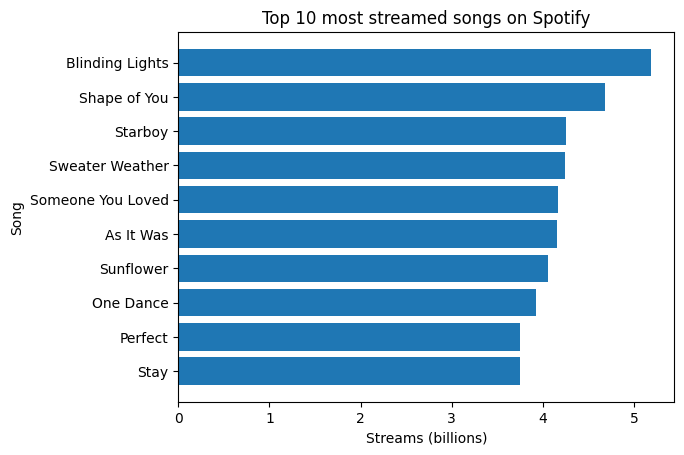

In [4]:
import matplotlib.pyplot as plt

top10 = df_db.sort_values("streams_billions", ascending=False).head(10)

plt.figure()
plt.barh(top10["title"], top10["streams_billions"])
plt.xlabel("Streams (billions)")
plt.ylabel("Song")
plt.title("Top 10 most streamed songs on Spotify")
plt.gca().invert_yaxis()
plt.show()


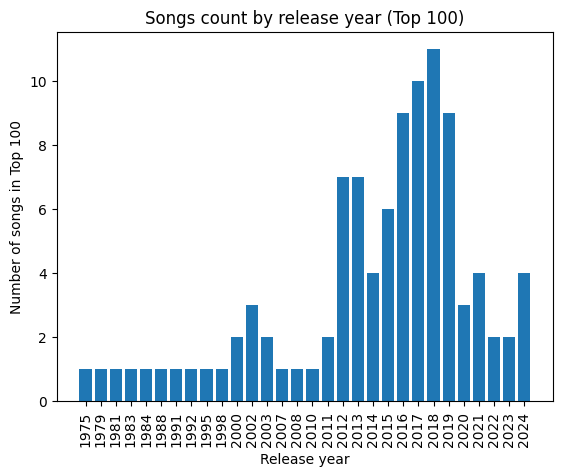

In [5]:
counts = df_db["year"].value_counts().sort_index()

plt.figure()
plt.bar(counts.index.astype(str), counts.values)
plt.xlabel("Release year")
plt.ylabel("Number of songs in Top 100")
plt.title("Songs count by release year (Top 100)")
plt.xticks(rotation=90)
plt.show()


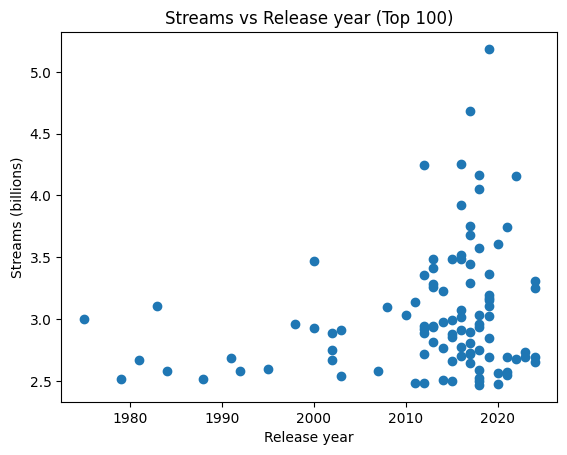

In [6]:
plt.figure()
plt.scatter(df_db["year"], df_db["streams_billions"])
plt.xlabel("Release year")
plt.ylabel("Streams (billions)")
plt.title("Streams vs Release year (Top 100)")
plt.show()
